In [1]:
# dependencies and libraries
import sqlite3
import io
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
from decimal import Decimal
from scipy.stats import wasserstein_distance, entropy
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline 
plt.rcParams["figure.figsize"] = (10, 8)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

In [2]:
conn = sqlite3.connect("SeeDb.db")
cursor = conn.cursor()
agg_funcs = ['avg', 'sum', 'count', 'min', 'max']
dimensions = ['sex', 'work_class', 'education', 'marital_status', 'occupation', 'relationship', 
                  'race', 'native_country', 'class']
measures = ['age','fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
epsilon = Decimal(1e-8)
n_partition = 10
S_row = 10000

In [3]:
#this cell has the functions definitions responsible to create, fill and query the database
#run this cell once whenever the notebook is disconnected to create the database and fill it locally
def create_fill_database(): 
  # Drop table if it exists
  cursor.execute('''DROP TABLE IF EXISTS census''')
  # Create table
  cursor.execute('''CREATE TABLE census
                (age int, work_class text, fnlwgt int, education text, education_num int, marital_status text, occupation text, relationship text, 
                race text, sex text, capital_gain int, capital_loss int, hours_per_week int, native_country text, class text)''')

  #fill the database
  df = pd.DataFrame(pd.read_csv('adultdata.csv'))
  for row in df.itertuples():
      cursor.execute('''
                  INSERT INTO census (age, work_class, fnlwgt, education, education_num, marital_status, occupation, relationship, 
                  race, sex, capital_gain, capital_loss, hours_per_week, native_country, class)
                  VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
                  ''',
                  (row.AGE, row.WORK_CLASS, row.FNLWGT, row.EDUCATION, row.EDUCATION_NUM, row.MARITAL_STATUS, row.OCCUPATION, row.RELATIONSHIP, 
                  row.RACE, row.SEX, row.CAPITAL_GAIN, row.CAPITAL_LOSS, row.HOURS_PER_WEEK, row.NATIVE_COUNTRY, row.CLASS)
                  )   
  conn.commit()
  #conn.close()
  
#create_fill_database()

## Phase-based Execution Framework:

In [4]:
def execute_query(query):
  """Returns a dataframe object with all the resulting records
  Arguments:
    query: The query to execute"""
  records_df = pd.read_sql_query(query, conn)
  return records_df


def partition_DB(n):
  """Returns a list of each partition starting point
  Arguments:
    n: number of partitions
    """
  records_count = execute_query("select count(*) from census").iloc[0]
  partition_size = int(records_count/n)
  range_start = []
  for i in range(n):
    range_start.append(i*partition_size)
  return range_start


def run_query_on_partition(query, start, end = -1):
  """Execute query on dataset partition
  Arguments:
    query: query to execute
    start: start of the dataset partition (not inclusive)
    end: end of the dataset partition (inclusive) (default -1 for the last partition)
  Returns:
    Dataframe containing result of executing the query on the dataset partition 
  """
  part1 = query
  part2 = ""
  idx = query.lower().find("group by")
  if idx != -1:
    part1 = query[:idx]
    part2 = query[idx:]
  #add the partitioning condition to the where clause
  if "where" in part1.lower():
    part1 += " AND rowid > " + str(start)
  else:
    part1 += " where rowid > " + str(start)
  #the last partition doesn't have an end condition 
  if end != -1:
    part1 += " AND rowid <= " + str(end)
  
  return execute_query(part1 + " " + part2)

print("Partitioning output: ")
print(partition_DB(10))
print("run_query_on_partition output: ")
print(run_query_on_partition("select * from census where sex='Male'", 1, 50))

Partitioning output: 
[0, 3016, 6032, 9048, 12064, 15080, 18096, 21112, 24128, 27144]
run_query_on_partition output: 
    age        work_class  fnlwgt     education  education_num  \
0    50  Self-emp-not-inc   83311     Bachelors             13   
1    38           Private  215646       HS-grad              9   
2    53           Private  234721          11th              7   
3    52  Self-emp-not-inc  209642       HS-grad              9   
4    42           Private  159449     Bachelors             13   
5    37           Private  280464  Some-college             10   
6    30         State-gov  141297     Bachelors             13   
7    32           Private  205019    Assoc-acdm             12   
8    34           Private  245487       7th-8th              4   
9    25  Self-emp-not-inc  176756       HS-grad              9   
10   32           Private  186824       HS-grad              9   
11   38           Private   28887          11th              7   
12   40           Privat

## Sharing-based Optimizations:

Implementation of First-Fit Decreasing Algorithm:

In [5]:
import operator
class Bin:
    def __init__(self, c):
        self.items = []
        self.remaining_cap = c
    
    def add(self, dimension, weight):
        self.items.append(dimension)
        self.remaining_cap -= weight

    def get_dimensions(self):
        return self.items

    def get_cap(self):
        return self.remaining_cap

def first_fit(dimensions, c):
    bins = []
    # add first bin
    bins.append(Bin(c))
    for dimension, weight in dimensions:
        need_new_bin = True
        for bin in bins:
            if bin.get_cap() >= weight:
                bin.add(dimension, weight)
                need_new_bin = False
                break
        if need_new_bin:
            bins.append(Bin(c))
            bins[-1].add(dimension, weight)

    return [b.get_dimensions() for b in bins]

def first_fit_dec(dimensions, c):
    sorted_dims = sorted(dimensions.items(), key=operator.itemgetter(1), reverse=True)
    return (first_fit(sorted_dims, c))

def get_distinct_dimension_counts_log10():
    count_str = []
    for d in dimensions:
        count_str.append('count(distinct {0}) as {0}'.format(d))
    count_str=", ".join(count_str)
    query = "SELECT {} FROM census".format(count_str)
    output = execute_query(query)
    log_values = np.log10(np.array(output)[0]) # because the output is [[2, 7, 16, 7, 14, 6, 5, 41, 2]]
    column_names = output.columns 
    return dict(zip(column_names, log_values))

dist_dimension_count_log10s = get_distinct_dimension_counts_log10()
first_fit_dec(dist_dimension_count_log10s, np.log10(S_row))

[['native_country', 'education', 'occupation'],
 ['work_class', 'marital_status', 'relationship', 'race', 'sex', 'class']]

In [6]:
def get_all_views():
  """Returns all possible views which is m*a*f views"""
  views = []
  for f in agg_funcs:
      for a in dimensions:
          for m in measures:
              views.append((a, m, f))

  return views

v=get_all_views()
print('Total number of views: {}'.format(len(v)))
#print(v)

Total number of views: 270


In [131]:
def get_views_with_same_group_by(views):
    """Returns a dictionary, the key is the group by attribute and the value is the view tuple"""
    d = defaultdict(list)

    for view in views:
        (a, m, f) = view
        d[a].append(view)
    return d
        
#print(len(get_views_with_same_group_by(get_all_views())))


def get_all_combined_queries(views):
    """Returns a list of all possible queries to be applied after applying the shared-based optimization
    Arguments:
        views: list of tuples in the form (a, m, f)
        use_multi_attr_group_by: True/False"""
    queries = []
    measures_str = []
    agg_funcs_list = []
    measures_list = []

    #Combine Multiple Aggregates
    v = get_views_with_same_group_by(views)
    keys = list(v.keys())
    views = list(v.values())
    for i in range(len(keys)):
        group_by_str = keys[i]
        for (a, m, f) in views[i]:
            measures_list.append(m)
            agg_funcs_list.append(f)
        if("avg" in agg_funcs_list and "count" not in agg_funcs_list):
            agg_funcs_list.append("count")
        for f in agg_funcs_list:
            for m in measures_list:
                measures_str.append('{0}({1}) as {0}_{1}'.format(f, m))
        #remove duplicates
        measures_str = list(set(measures_str))
        measures_str_combined = ', '.join(measures_str)
        #Combine reference and target queries
        ref_target_string = """, CASE WHEN marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') THEN 'Married' ELSE 'Unmarried' END Grouped_Marital_Status """
        measures_str_combined += ref_target_string
        
        queries.append('select {1}, {0} from census group by {1};'.format(measures_str_combined, group_by_str))
    return queries

    
print(get_all_combined_queries(get_all_views())[:3])    

["select sex, count(fnlwgt) as count_fnlwgt, min(fnlwgt) as min_fnlwgt, sum(capital_loss) as sum_capital_loss, count(capital_gain) as count_capital_gain, avg(hours_per_week) as avg_hours_per_week, max(capital_loss) as max_capital_loss, avg(capital_gain) as avg_capital_gain, max(fnlwgt) as max_fnlwgt, avg(age) as avg_age, count(age) as count_age, sum(fnlwgt) as sum_fnlwgt, max(hours_per_week) as max_hours_per_week, max(capital_gain) as max_capital_gain, sum(age) as sum_age, count(education_num) as count_education_num, max(age) as max_age, min(capital_loss) as min_capital_loss, sum(hours_per_week) as sum_hours_per_week, min(hours_per_week) as min_hours_per_week, count(hours_per_week) as count_hours_per_week, avg(education_num) as avg_education_num, avg(fnlwgt) as avg_fnlwgt, sum(education_num) as sum_education_num, avg(capital_loss) as avg_capital_loss, count(capital_loss) as count_capital_loss, min(age) as min_age, min(education_num) as min_education_num, max(education_num) as max_educa

In [132]:
def combine_multiple_group_by(queries):
    #it takes queries after applying the multiple aggregate and target and reference combining
    #TODO
    return queries

In [133]:
def execute_combined_queries_on_partition(combined_queries, part_start, part_end):
    results = []
    for query in combined_queries:
        result_df = run_query_on_partition(query, part_start, part_end)
        results.append(result_df)
    return results

### **Pruning based optimization**

Calculate utilities for combined GROUP-BYs:

In [134]:
def kl_divergence(target_agg_vals, ref_agg_vals):
    # normalize
    target_agg_vals = np.array(target_agg_vals, dtype=float)
    ref_agg_vals = np.array(ref_agg_vals, dtype=float)
    t_sum = sum(target_agg_vals)
    r_sum = sum(ref_agg_vals)
    t_norm = [i/t_sum for i in target_agg_vals]
    r_norm = [i/r_sum for i in ref_agg_vals]
    # calculate divergence
    return entropy(t_norm, r_norm)

def calculate_utility(target_agg_vals, ref_agg_vals):
    # Earth Mover's Distance
    # return wasserstein_distance(target_agg_vals, ref_agg_vals)
    # KL Divergence
    return kl_divergence(target_agg_vals, ref_agg_vals)

def get_target_and_ref_aggregated_fms(aggregated_fms):
    # Now we make sure the same values for dimension attributes exist in the mapping for both target and reference. 
    #Then, we can return the list of aggregate function values corresponding to those dimension values to be used for calculating utility.
    target_fms = aggregated_fms[0]
    ref_fms = aggregated_fms[1]
    dim_agg_pairs = defaultdict(list)
    target_agg_vals = []
    ref_agg_vals = []

    for dimension_val, agg_val in target_fms.items():
        if agg_val == 0:
            temp = epsilon
        else:
            temp = agg_val
        dim_agg_pairs[dimension_val].append(temp)

    for dimension_val, agg_val in ref_fms.items():
        if dimension_val not in dim_agg_pairs: # dim_val in ref but not in target
            dim_agg_pairs[dimension_val].append(epsilon)
        
        if agg_val == 0:
            temp = epsilon
        else:
            temp = agg_val
        dim_agg_pairs[dimension_val].append(temp)

    for dim_val, agg_vals in dim_agg_pairs.items():
        if len(agg_vals) < 2: # dim_val in target but not in ref
            dim_agg_pairs[dim_val].append(epsilon)
        
    for agg_vals in dim_agg_pairs.values():
        target_agg_vals.append(agg_vals[0])
        ref_agg_vals.append(agg_vals[1])

    return target_agg_vals, ref_agg_vals

def calculate_dimension_avg(fm_values, count_ms):
    agg_val_sum = 0
    count_sum = 0
    for fm, count in zip(fm_values, count_ms):
        count_sum += count
        agg_val_sum += fm * count
    if count_sum != 0:
        return agg_val_sum/count_sum
    else:
        return epsilon

def calculate_aggregate_value(dim_val, fm_values, agg_func, result, m, a):
    if agg_func == 'avg':
        count_ms=list(result[result[a] == dim_val]["count_{}".format(m)]) # count(m) for the corresponding row
        return calculate_dimension_avg(count_ms, fm_values)
    elif agg_func == 'min':
        return min(fm_values)
    elif agg_func == 'max':
        return max(fm_values)
    elif agg_func == 'sum':
        return sum(fm_values)
    elif agg_func == 'count':
        return sum(fm_values)
    else:
        raise ValueError("Aggregate function cannot be {} for dimension value {}!".format(agg_func, dim_val))


def calc_utilities(results,views=get_all_views()):
    utilities = {}
    aggregated_fms = [defaultdict(list), defaultdict(list)]
    for (a, m, f) in views:
        for i in range(len(results)): # for target and reference results
            result = results[i]
            for dim_val in result[a].unique(): # for every value of a dimension
                # if dim_val == '?':
                #     continue
                fm_values=list(result[result[a] == dim_val]["{}_{}".format(f,m)]) # get all of corresponding f(m) values
                aggregated_fms[i][dim_val] = calculate_aggregate_value(dim_val, fm_values, f, result, m, a)
                target_agg_vals, ref_agg_vals = get_target_and_ref_aggregated_fms(aggregated_fms)
        utilities[(a, m, f)] = (calculate_utility(target_agg_vals, ref_agg_vals))
    return utilities

def calc_utilities_given_views(results,views):
    utilities = {}
    aggregated_fms = [defaultdict(list), defaultdict(list)]
    for (a, m, f) in views:
        for i in  range(len(results)): # for target and reference results
            result = None
            for query_result in results[i]:
                if set((a,"{}_{}".format(f,m))).issubset(query_result.columns):
                    result = query_result
                    break

                
            for dim_val in result[a].unique(): # for every value of a dimension
                # if dim_val == '?':
                #     continue
                fm_values=list(result[result[a] == dim_val]["{}_{}".format(f,m)]) # get all of corresponding f(m) values
                aggregated_fms[i][dim_val] = calculate_aggregate_value(dim_val, fm_values, f, result, m, a)
                target_agg_vals, ref_agg_vals = get_target_and_ref_aggregated_fms(aggregated_fms)
        utilities[(a, m, f)] = (calculate_utility(target_agg_vals, ref_agg_vals))
    return utilities

#view_utilities = calc_utilities(results[0:2]) # we should change here Hadeel
#view_utilities

In [135]:
import math
def Hoeffding_Serfling_Error(m,N,delta=10**-2):
    return math.sqrt(    (1-(m-1)/N) *  (  2*math.log(math.log(m))  +  math.log(math.pi**2/(3*delta))  )/(2*m))

In [136]:
import heapq
def confidence_interval_pruning(upperbound,lowerbound,optimized_queries,k):
    top_k_queries = set(heapq.nlargest(k,upperbound,key = upperbound.get))
    print(top_k_queries)
    top_k_lowest_lowerbound = min(lowerbound[q] for q in top_k_queries)
    for query in  optimized_queries:
        if query not in top_k_queries:
            if upperbound[query]<top_k_lowest_lowerbound:
                  optimized_queries.remove(query)
    return optimized_queries

In [137]:
def MAB_pruning(current_mean,optimized_queries,k):
    top_k_1 = heapq.nlargest(k+1,current_mean,key = current_mean.get)
    sorted_queries = sorted(list(optimized_queries),key=lambda q: current_mean[q],reverse=True) 
    lowest = min(current_mean[q] for q in current_mean)
    delta_1 = top_k_1[0][1]-top_k_1[k-1][1]
    delta_n = top_k_1[-1][1]-lowest
    if delta_1>delta_n:
        sorted_queries.pop(0)
    else:
        sorted_queries.pop(-1)
    return set(sorted_queries)

In [156]:
def prune_views(m,top_views,target_view_data, reference_view_data, running_mean, prune_method = "CI",N=10,k=5):
    utilities=calc_utilities_given_views([target_view_data,reference_view_data],top_views)
    for q in top_views:
        running_mean[q] = (running_mean[q]*(m-1)+ utilities[q])/m
    print(running_mean)
    if (m ==1):
        return top_views
    if prune_method == "CI":
        upperbounds,lowerbounds = {},{}
        confidence_interval = Hoeffding_Serfling_Error(m,N)
        for q in top_views:
            upperbounds[q] =  running_mean[q]+confidence_interval
            lowerbounds[q] =  running_mean[q]-confidence_interval
        return confidence_interval_pruning(upperbounds,lowerbounds,top_views,k)
    elif prune_method == "MAB":
        return MAB_pruning(running_mean,top_views,k)
    else:
        return top_view
        
    

### **Visualizing top k queries:**

In [157]:
def get_top_k_views(view_utilities, k):
    return sorted(view_utilities.items(), key= lambda item: item[1], reverse=True)[:k]

#get_top_k_views(view_utilities, 10)

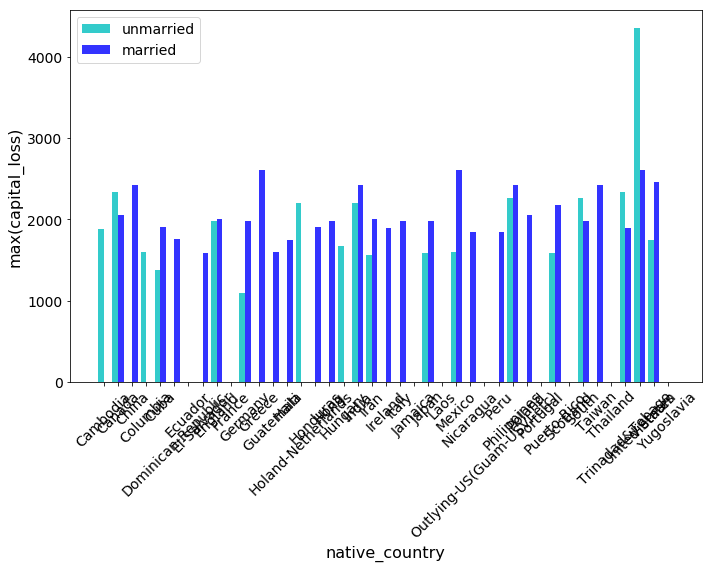

In [160]:
#This list is used only for testing, it should be removed 
views_list = [
    #('marital_status', 'fnlwgt', 'sum'),
    #('relationship', 'capital_gain', 'sum'),
    ('native_country', 'capital_loss', 'max')]


def draw_views(views_list):
    for view in views_list:
        group_by, measurement, agg_func = view
        if group_by == 'marital_status':
            query = """select CASE WHEN marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') THEN 'Married' ELSE 'Unmarried' END Grouped_Marital_Status
            , {}({}) from census Group by Grouped_Marital_Status;""".format(agg_func, measurement)
            group_by = "Grouped_Marital_Status"
            res = execute_query(query)
            target_df = res.loc[res['Grouped_Marital_Status']=='Married'].reset_index(drop=True)
            ref_df = res.loc[res['Grouped_Marital_Status']=='Unmarried'].reset_index(drop=True)

        else:    
            target_query = "select {0}, {1}({2}) from census where marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') Group By {0};".format(group_by, agg_func, measurement)
            ref_query = "select {0}, {1}({2}) from census where marital_status in ('Never-married', 'Widowed','Divorced', 'Separated') Group By {0};".format(group_by, agg_func, measurement)
            target_df = execute_query(target_query)
            ref_df = execute_query(ref_query)
            
        #populate both df with the same values for the groups so target and ref have same groups
        for t in target_df[group_by]:                  
            if t not in list(ref_df[group_by]):
                ref_df.loc[len(ref_df.index)] = [t, 0] 
        for r in ref_df[group_by]:
            if r not in list(target_df[group_by]):
                target_df.loc[len(target_df.index)] = [r, 0]
        target_df = target_df.sort_values(by=[group_by])
        ref_df = ref_df.sort_values(by=[group_by])

        indices = list(target_df.columns)
        target_val = target_df[indices[1]]
        ref_val = ref_df[indices[1]]
        
        # create plot
        n_groups = len(target_df)
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.4
        opacity = 0.8

        rects1 = plt.bar(index, ref_val, bar_width, alpha=opacity, color='c', label='unmarried')
        rects2 = plt.bar(index + bar_width, target_val, bar_width, alpha=opacity, color='b', label='married')
        
        plt.xlabel('{}'.format(group_by), fontsize = 16)
        plt.ylabel('{}({})'.format(agg_func, measurement), fontsize = 16)
                    
        plt.xticks(index + 0.5 * bar_width, ref_df[indices[0]], rotation=45)
        plt.legend(fontsize=14)

        plt.tight_layout()
        plt.show()


draw_views(views_list)


phase: 0 start
defaultdict(<class 'float'>, {('sex', 'age', 'avg'): 0.06934399574524416, ('sex', 'fnlwgt', 'avg'): 0.06934399574524416, ('sex', 'education_num', 'avg'): 0.06934399574524416, ('sex', 'capital_gain', 'avg'): 0.06934399574524416, ('sex', 'capital_loss', 'avg'): 0.06934399574524416, ('sex', 'hours_per_week', 'avg'): 0.06934399574524416, ('work_class', 'age', 'avg'): 24.936492872063244, ('work_class', 'fnlwgt', 'avg'): 24.936492872063244, ('work_class', 'education_num', 'avg'): 24.936492872063244, ('work_class', 'capital_gain', 'avg'): 24.936062116133815, ('work_class', 'capital_loss', 'avg'): 24.936062116133815, ('work_class', 'hours_per_week', 'avg'): 24.936492872063244, ('education', 'age', 'avg'): 24.537247758391715, ('education', 'fnlwgt', 'avg'): 24.537247758391715, ('education', 'education_num', 'avg'): 24.537247758391715, ('education', 'capital_gain', 'avg'): 24.56152420771087, ('education', 'capital_loss', 'avg'): 24.547892862411242, ('education', 'hours_per_week', 

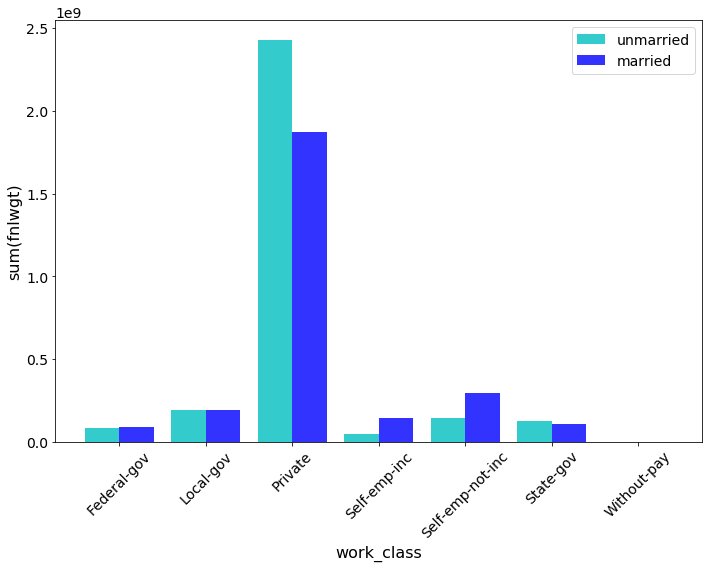

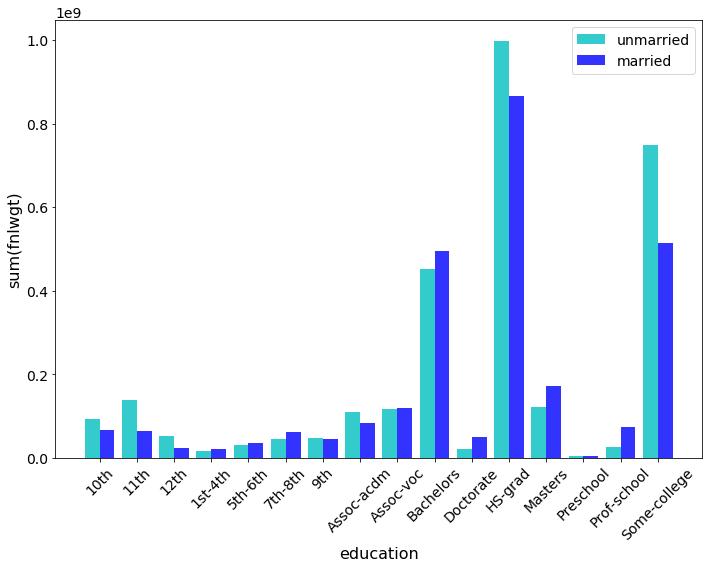

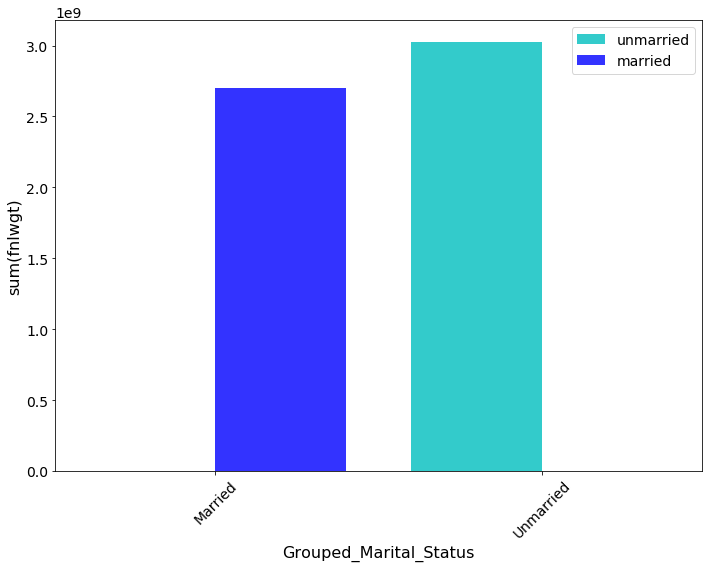

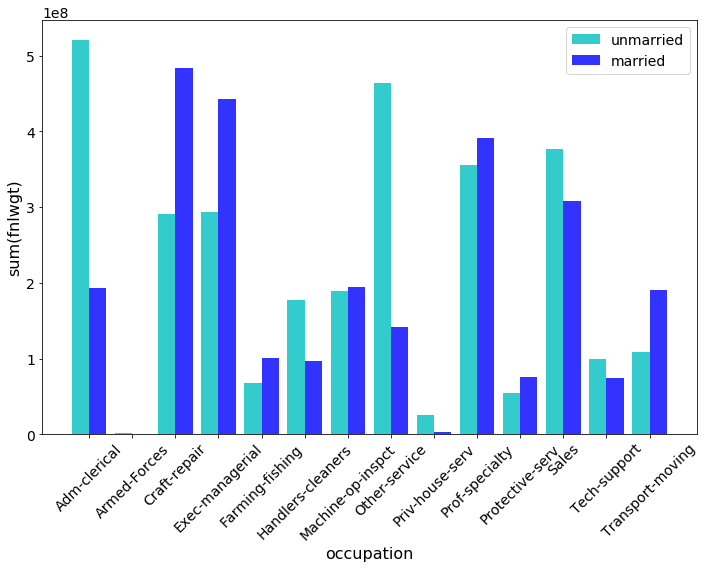

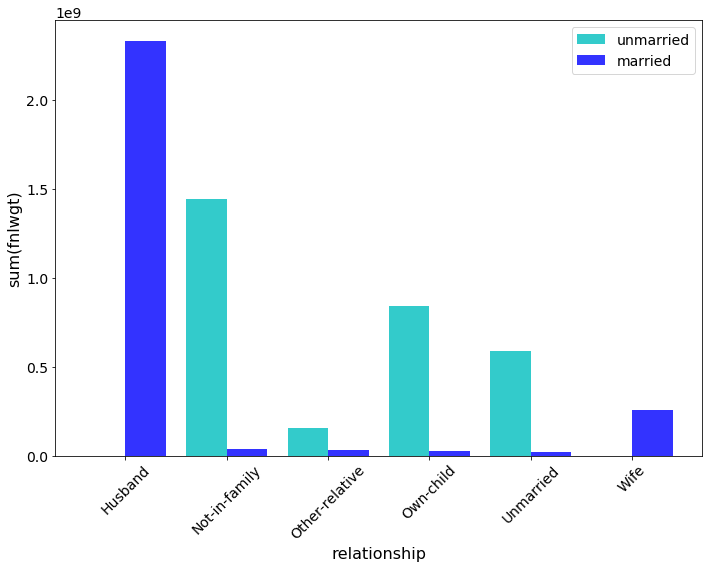

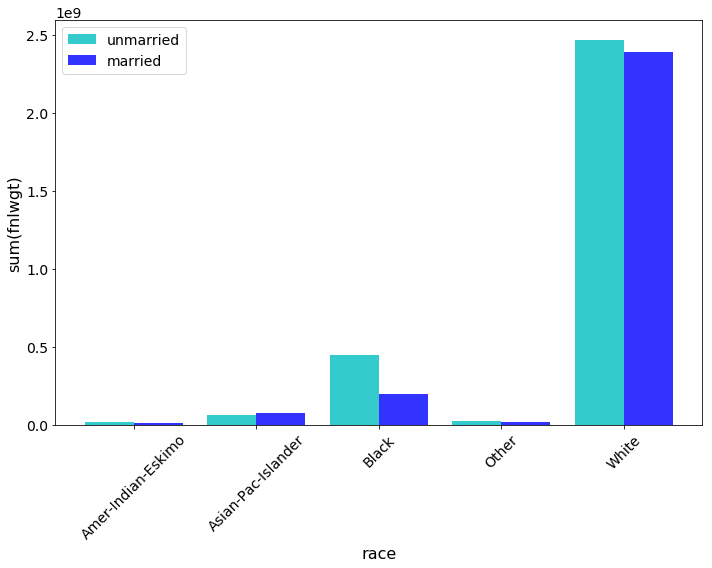

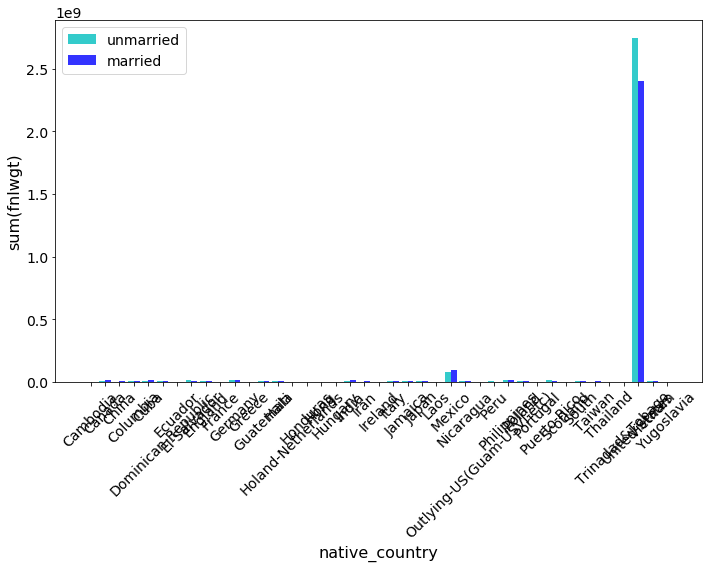

In [159]:

def apply_algorithms(apply_multiple_group_by):
    #partition the db
    n = 10
    all_partitions_start = partition_DB(n)

    # The execution engine begins with the entire set of aggregate views under consideration. 
    top_views = get_all_views()
    running_mean = defaultdict(float)
    for i in range(n):
        print("phase:",i,"start")
        # During phase i, SEEDB updates partial results for the views still under consideration using the ith fraction of the dataset. 
        part_start = all_partitions_start[i]
        part_end = -1 if (i == n-1) else all_partitions_start[i+1]
        # The execution engine applies sharing-based optimizations to minimize scans on this ith fraction of the dataset. 
        # combined queries will start with the entire set of aggregate views under consideration.
        combined_queries = get_all_combined_queries(top_views)
        
        if apply_multiple_group_by:
            combine_multiple_group_by(combined_queries)
            
        target_view_data = []
        reference_view_data = []

        result = execute_combined_queries_on_partition(combined_queries, part_start, part_end)
        for res in result:
            # results of executing the combined queries on ref and target, each item will contain a dataframe with the rows resulting
            # from executing the combined query on the reference and the target data
            
            target_view_data.append(res.loc[res['Grouped_Marital_Status']=='Married'])
            reference_view_data.append(res.loc[res['Grouped_Marital_Status']=='Unmarried'])
            
        # At the end of phase i, the execution engine uses pruning-based optimizations to determine which aggregate views to discard.    
        #print(len(target_view_data),target_view_data[0].columns)
        #print(len(target_view_data),reference_view_data[0].columns)
        top_views = prune_views(i+1,top_views,target_view_data, reference_view_data,running_mean,k=5)
            
        print("Remaining views:",len(top_views))
        
        # These two lines should be inside the prune function or in a similar way
        # views_utilities[i].append(calc_utilities(target_view_data, reference_view_data))
        # top_k_views = get_top_k_views(view_utilities, 5)

    #draw the top k views, printing only 3 for testing
    draw_views(top_views)
    

apply_algorithms(False)

In [155]:
apply_algorithms()

TypeError: apply_algorithms() missing 1 required positional argument: 'apply_multiple_group_by'

In [ ]:
# %%time

# n_splits = 10
# split_path = Path('/content/census.splits')
# split_path.mkdir(parents=True, exist_ok=True)

# df = pd.DataFrame(pd.read_csv('/content/adultdata.csv'))
# df.columns = [i.replace('-', '_') for i in df.columns]

# df_split= np.array_split(df, n_splits)

# for i in range(len(df_split)):
#     df_split[i].to_csv(Path(split_path / "census.split_{}.csv".format(i)), encoding='utf-8', index=False)

# !zip -r /content/census.splits.zip /content/census.splits

In [ ]:
# for i in range(n_splits):
#     cur.executescript('''drop table if exists split_{};
#                         create table split_{}
#                         (age int, work_class text, fnlwgt int, education text, education_num int, marital_status text, occupation text, relationship text, 
#                         race text, sex text, capital_gain int, capital_loss int, hours_per_week int, native_country text, class text)'''.format(i, i))
    
#     # change this to psql
#     df = pd.DataFrame(pd.read_csv('/content/census.splits/census.split_{}.csv'.format(i)))
#     for row in df.itertuples():
#         cur.execute('''
#                   INSERT INTO split_{} (age, work_class, fnlwgt, education, education_num, marital_status, occupation, relationship, 
#                   race, sex, capital_gain, capital_loss, hours_per_week, native_country, class)
#                   VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
#                   '''.format(i),
#                   (row.AGE, row.WORK_CLASS, row.FNLWGT, row.EDUCATION, row.EDUCATION_NUM, row.MARITAL_STATUS, row.OCCUPATION, row.RELATIONSHIP, 
#                   row.RACE, row.SEX, row.CAPITAL_GAIN, row.CAPITAL_LOSS, row.HOURS_PER_WEEK, row.NATIVE_COUNTRY, row.CLASS)
#                   )   

# conn.commit()
# census_view_query = 'drop view if exists census_view; create view census_view as select * from split_0'
# for i in range(1, n_splits):
#     census_view_query += ' union select * from split_{}'.format(i)
# census_view_query += ';'
# cur.executescript(census_view_query)
# conn.commit()

In [ ]:
# n_phases = n_splits
# for i in range(n_phases):
#     query = """drop view if exists split_{0}_married; create view split_{0}_married as select * from split_{0} where marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent','Separated');
#            drop view if exists split_{0}_unmarried; create view split_{0}_unmarried as select * from split_{0} where marital_status in ('Never-married', 'Widowed','Divorced');""".format(i)
#     cur.executescript(query)
#     conn.commit()